In [3]:
!pip3 install open3d

You are using pip version 18.0, however version 20.2b1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
import math
import scipy
from tqdm import tqdm_notebook

In [2]:
pcd = o3d.io.read_point_cloud("scene_dense_sber.ply")

In [3]:
point_cloud_in_numpy = np.asarray(pcd.points)
point_cloud_in_numpy 

array([[-3.81545782, -0.34077999,  1.90094817],
       [-3.81499481, -0.34146237,  1.90027225],
       [-3.81462741, -0.34079236,  1.89844096],
       ...,
       [-4.59054852,  0.53128552,  1.52766979],
       [-4.58382034,  0.53391516,  1.59634221],
       [-4.49518633,  0.53137571,  2.00885963]])

# NDT

Был вариант, для инициализации А использовать VoxelGrid, но я так и не придумала, как вытащить оттуда соотношение кубик-массив точек в нем, поэтому делим каждую координату нацело на s, получаем координаты кубика для каждой точки.

In [4]:
s = 0.5
te = 0.01
A = point_cloud_in_numpy // s # разбиение PCD на кубики
Q = np.array([0, 0, 0]) # плоские NDT ячейки
Q_points = []
P = [] # остальные ячейки

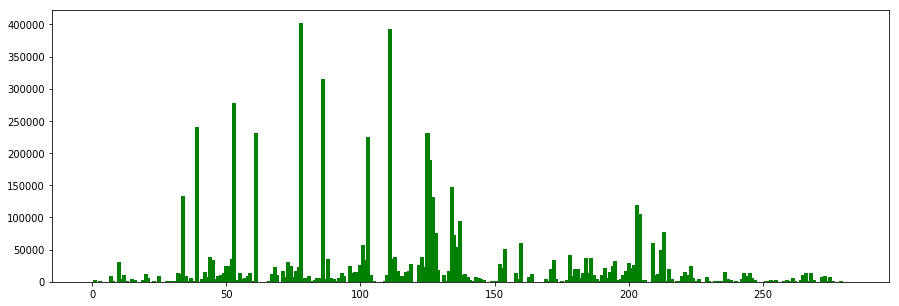

In [5]:
unique,counts=np.unique(A,axis=0, return_counts=True)
plt.figure(figsize=(15,5))
plt.bar(range(0, len(counts)), counts, width=1.5, color='g')
plt.show()

In [6]:
def IRLS_find_norm(points):
    cov = np.cov(np.array(points).T)
    #print("cov = ", cov)
    lambd, e = np.linalg.eig(cov)
    o = lambd.argsort()
    lambd = lambd[o]
    e = e[o]
    gamma = 1e-6
    k_w = 2.985
    n = e[0]
    g = np.mean(points, axis = 0)
    X_prev = np.zeros(3)
    for i in range(100):
        n_old = n
        r = (points - g) @ n
        w = np.exp(-(r ** 2 / k_w ** 2))
        X_k = np.average(points - g - X_prev, axis=0, weights=w)
        vec = (points - g - X_k)
        X_prev = X_k
        C = (vec.T * w) @ vec
        w, v = np.linalg.eig(C)
        o = w.argsort()
        w = w[o]
        v = v[o]
        n = v[0]
        convg = np.linalg.norm(n_old - n) / np.linalg.norm(n_old)
        if convg < gamma:
            break
    return n

In [7]:
mu = []
normals = []
for ind, i in tqdm_notebook(list(enumerate(unique))):
    this_cell = np.array(point_cloud_in_numpy[np.where(np.prod(A == i, axis = -1))])
    if (len(this_cell) <= 3):
        P.append(this_cell)
        continue
    mu.append(np.mean(this_cell))
    cov = np.cov(np.array(this_cell).T)
    #print("cov = ", cov)
    w, v = np.linalg.eig(cov)
    o = w.argsort()
    w = w[o]
    v = v[o]
    #print("values = ", w)
    if (abs(w[0] / w[1]) <= te):
        Q = np.vstack((Q, i))
        Q_points.append(list(this_cell))
        normals.append(IRLS_find_norm(this_cell))
    else:
        P.append(list(this_cell))
Q = Q[1:,]
P = np.concatenate(P)


[[-14.   0.   3.]
 [-13.   0.   4.]
 [-11.   0.   4.]
 [-11.   1.   3.]
 [-10.  -1.   1.]
 [-10.   0.   4.]
 [-10.   1.   1.]
 [-10.   1.   3.]
 [ -9.   0.   4.]
 [ -9.   1.   0.]
 [ -9.   1.   2.]
 [ -9.   1.   3.]
 [ -8.  -1.  -2.]
 [ -8.  -1.   2.]
 [ -8.  -1.   3.]
 [ -8.   0.   4.]
 [ -8.   1.   2.]
 [ -8.   1.   3.]
 [ -7.  -1.  -2.]
 [ -7.  -1.  -1.]
 [ -7.  -1.   0.]
 [ -7.  -1.   1.]
 [ -7.   0.  -1.]
 [ -7.   0.   0.]
 [ -7.   0.   4.]
 [ -7.   1.  -3.]
 [ -7.   1.  -2.]
 [ -7.   1.  -1.]
 [ -7.   1.   0.]
 [ -7.   1.   1.]
 [ -7.   1.   2.]
 [ -7.   1.   3.]
 [ -6.  -1.  -2.]
 [ -6.   0.   3.]
 [ -6.   1.  -2.]
 [ -6.   1.   1.]
 [ -6.   1.   2.]
 [ -6.   1.   3.]
 [ -5.  -1.  -2.]
 [ -5.   0.  -5.]
 [ -5.   0.   1.]
 [ -5.   1.  -3.]
 [ -5.   1.  -2.]
 [ -4.   0.  -6.]
 [ -4.   0.  -3.]
 [ -4.   1.  -3.]
 [ -4.   1.  -2.]
 [ -3.   0.  -3.]
 [ -3.   1.  -3.]
 [ -3.   1.  -2.]
 [ -2.  -1.  -4.]
 [ -2.  -1.  -2.]
 [ -2.   0.  -3.]
 [ -2.   0.   1.]
 [ -2.   1.  -3.]
 [ -2.   

In [8]:
Q_points = np.array(Q_points)
normals = np.array(normals)

# RANSAC

In [10]:
points = Q_points[8]
gk = np.mean(points, axis = 0)
nk = IRLS_find_norm(points)
cov = np.cov(np.array(this_cell).T)
#print("cov = ", cov)
w, v = np.linalg.eig(cov)
w = np.sort(w)
print(w)
vec = np.tensordot(np.linspace(0, 0.1), nk, axes=0) + gk
pcd.points = o3d.utility.Vector3dVector(np.concatenate((points, vec)))
pcd.colors = o3d.utility.Vector3dVector([[1, 0, 0]] * len(points) + [[0, 1, 0]] * len(vec))
o3d.visualization.draw_geometries([pcd])   

[1.44600099e-05 1.56957367e-04 2.36103045e-03]


In [11]:
def plane(Q, P, Q_points, normals):
    k_max = 50
    nu = 0.95
    delta_d = 0.08
    n = 0
    delta_theta = 0.25
    k = 0
    Psi = np.zeros(len(Q), dtype=np.bool)
    Psi_size = 0
    Psi_points = []
    k = 1
    while k < k_max:
        c = np.random.choice(range(0, len(Q)))
        cell = Q[c]
        points = Q_points[c]
        gk = np.mean(points, axis = 0)
        nk = normals[c]
        Ik = np.zeros(len(Q), dtype=np.bool)
        cnt = 0
        Ik_points = []
        for i, v in enumerate(Q):
            g_i = np.mean(Q_points[i], axis = 0)
            n_i = normals[i]
            d_i = np.dot((g_i - gk), nk) / np.linalg.norm(nk)
            theta_i = 1 - np.abs(np.dot(nk, n_i)) / (np.linalg.norm(nk) * np.linalg.norm(n_i))
            if (np.abs(d_i) < delta_d and theta_i < delta_theta):
    #             print(d_i, theta_i)
    #             print(n_i, nk)
                Ik[i] = 1
                cnt += 1
                Ik_points += Q_points[i]
        if cnt > Psi_size:
            Psi = Ik
            Psi_points = Ik_points
            Psi_size = cnt
            n = nk
            g = gk
            Pn = Psi_size / len(Q)
            k_max = math.ceil(math.log(1 - nu) / math.log(1 - Pn))
        k += 1
#     print(Psi_size)


#     print(Psi_points[0])
#     print(np.shape(Psi_points))
    
    P_mask = np.zeros(len(P), dtype=np.bool)
    for j, i in enumerate(P):
        d_i = np.inner(i - g, n) / np.linalg.norm(n)
        if (np.abs(d_i) < delta_d):
            P_mask[j] = 1 
            Psi_points += [i]
    return n, g, np.array(Psi_points), Q[~Psi], Q_points[~Psi], P[~P_mask], normals[~Psi]
#     print(Psi_points[0])
#     print(np.shape(Psi_points))  

In [ ]:
Q = Q_old
P = P_old
Q_points = Q_points_old
normal_points = normals_old
normals = []
result_points = np.zeros((0, 3))
result_colors = np.zeros((0, 3))
for i in range(10):
    n, g, Psi_points, Q, Q_points, P, normal_points = plane(Q, P, Q_points, normal_points)
#     print(n)
#     print(g)
    normals += n
    print(len(Psi_points))
    if len(Psi_points) < 10000:
        break
    result_points = np.concatenate((result_points, Psi_points))
    result_colors = np.concatenate((result_colors, np.repeat(np.random.random(3).reshape(1, 3), len(Psi_points), axis = 0)))
pcd.points = o3d.utility.Vector3dVector(result_points)
pcd.colors = o3d.utility.Vector3dVector(result_colors)
o3d.visualization.draw_geometries([pcd])

434767
528611
2231693
201834
48237
226079
116248
116887
60217


In [35]:
pcd.points = o3d.utility.Vector3dVector(result_points)
pcd.colors = o3d.utility.Vector3dVector(result_colors)
o3d.visualization.draw_geometries([pcd])

In [17]:
n, g, Psi_points, NQ, NQ_points, NP, Nnormals = plane(Q, P, Q_points, normals)

In [18]:
#print(sum(map(len, NQ_points)) + len(NP) + len(Psi_points), '=', sum(map(len, Q_points)) + len(P))

5905097 = 5905097


In [19]:
pcd.points = o3d.utility.Vector3dVector(Psi_points)
pcd.colors = o3d.utility.Vector3dVector([n] * len(Psi_points))
o3d.visualization.draw_geometries([pcd])

In [ ]:
print(Psi_points[:,2].min(), Psi_points[:,2].max())

# Определение потолка/пола/перекрытий

In [ ]:
def sep(arr):
    l = min(z)
    h = max(z)
    mid = (h - l) / 2
    ind = np.searchsorted(z, mid)
    z1 = z[:ind]
    z2 = z[ind:]
    floors = []
    lwth = # нижний порог
    upth = # верхний порог
    if len(z1) / (mid - l) > upth:
        floors.append((mid, l))
    elif len(z1) / (mid - l) > lwth:
        floors += sep(z1)
    if len(z2) / (h - mid) > upth:
        floors.append((mid, h))
    elif len(z2) / (h - mid) > lwth:
        floors += sep(z2)
    return floors

In [ ]:
z = np.sort(point_cloud_in_numpy[:,1])
z = sep(z)
final_f = []
for i, v in enumerate(Psi_points):
    theta_i = 1 - np.abs(np.dot([0, 1, 0], normals[i])) / (np.linalg.norm([0, 1, 0]) * np.linalg.norm(normals[i]))
    if (theta_i <= 0.25):
        mean_z = np.mean(v[:,1])
        for j in floors:
            if mean_z <= j[1] and mean_z >= j[0]:
                final_f += v
Psi_points = Psi_points[~final_f] # тут остались только стены


# Делаем Mesh из стен и потолков с полом

In [ ]:
walls.points = o3d.utility.Vector3dVector(Psi_points)
walls.colors = o3d.utility.Vector3dVector([[1, 0, 0] * len(Psi_points))
poisson_mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(walls, 
                                                                         depth=8, 
                                                                         width=0, 
                                                                         scale=1.1, 
                                                                         linear_fit=False)[0]
bbox = walls.get_axis_aligned_bounding_box()
p_mesh_crop = poisson_mesh.crop(bbox)
o3d.io.write_triangle_mesh(output_path+"walls.ply", walls)

In [ ]:
floors.points = o3d.utility.Vector3dVector(final_f)
floors.colors = o3d.utility.Vector3dVector([[1, 0, 0] * len(final_f))
poisson_mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(floors, 
                                                                         depth=8, 
                                                                         width=0, 
                                                                         scale=1.1, 
                                                                         linear_fit=False)[0]
bbox = floors.get_axis_aligned_bounding_box()
p_mesh_crop = poisson_mesh.crop(bbox)
o3d.io.write_triangle_mesh(output_path+"floors.ply", floors)

# Делаем план помещения

In [ ]:
plan = Psi_points[:,0:3:2]